## Going4 Project 

### 1. 데이터 불러오기 및 버전 확인하기

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


In [3]:
print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


### 1. Augmentation을 적용한 데이터셋 만들기

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteG091CV/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteG091CV/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
=3


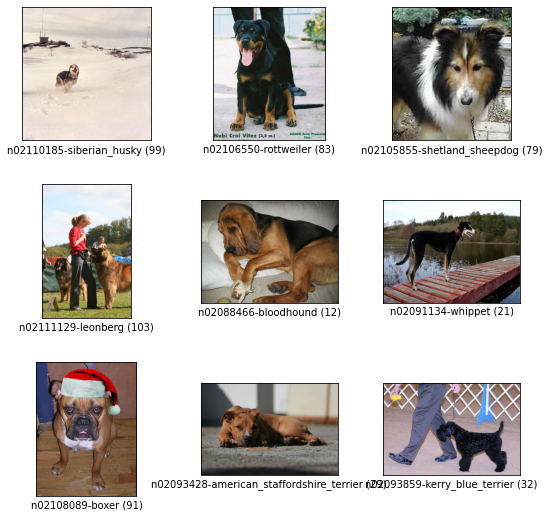

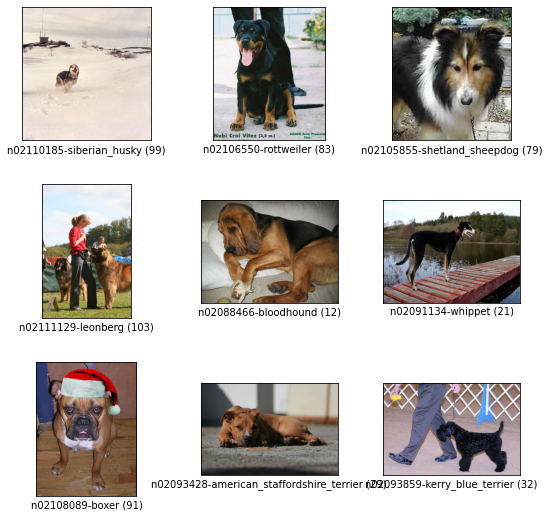

In [5]:
tfds.show_examples(ds_train, ds_info)

## 함수 정의하기

In [6]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

print('=3')

=3


## CutMix 구현하기

In [7]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [8]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    middle_left = image_a[y_min:y_max, 0:x_min, :]  # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :]  # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left, middle_center, middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom], axis=0)
    
    return mixed_img

## 라벨 섞기

In [9]:
# 섞인 두 이미지에 대하여 라벨을 만들때 적절한 비율로 라벨을 합쳐주는 함수이다.
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [10]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


## Mixup Augmentation 구현하기

In [11]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [12]:
# 위에서 구현한 함수를 활용해 배치 단위의 maxup 함수를 구현한다.
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


In [13]:
def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    onehot_imgs = []
    onehot_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        if len(label_a.shape)==0:
            label_a = tf.one_hot(label_a, num_classes)
        
        onehot_imgs.append(image_a)
        onehot_labels.append(label_a)

    onehot_imgs = tf.reshape(tf.stack(onehot_imgs),(batch_size, img_size, img_size, 3))
    onehot_labels = tf.reshape(tf.stack(onehot_labels),(batch_size, num_classes))
    return onehot_imgs, onehot_labels

In [14]:

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


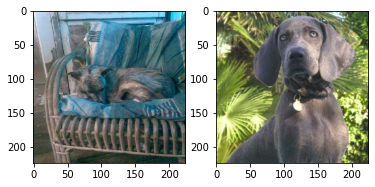

In [15]:
# with_aug를 False로 줘서 augmentation이 적용되지 않게하고, 다른 하나는
# True를 줘서 augmentation이 적용되게 한다.
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

# 데이터셋에서 이미지 2개를 가져옵니다.
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break
        
plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [16]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [17]:
# Augmentation을 적용한 데이터셋으로 학습시킬 ResNet을 하나 더 만든다.
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [18]:
# cutmix를 적용한 데이터셋으로 학습시킬 ResNet을 하나 더 만든다.
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [19]:
# mixup을 적용한 데이터셋으로 학습시킬 ResNet을 하나 더 만든다.
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [20]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

print('=3')

=3


In [21]:
EPOCH = 15

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 112s 127ms/step - loss: 2.1849 - accuracy: 0.4551 - val_loss: 3.4009 - val_accuracy: 0.2056
Epoch 2/15
750/750 [==============================] - 95s 127ms/step - loss: 0.6764 - accuracy: 0.8138 - val_loss: 1.0228 - val_accuracy: 0.6933
Epoch 3/15
750/750 [==============================] - 95s 127ms/step - loss: 0.1865 - accuracy: 0.9656 - val_loss: 0.9478 - val_accuracy: 0.7249
Epoch 4/15
750/750 [==============================] - 94s 125ms/step - loss: 0.1009 - accuracy: 0.9873 - val_loss: 0.9611 - val_accuracy: 0.7242
Epoch 5/15
750/750 [==============================] - 96s 128ms/step - loss: 0.0289 - accuracy: 0.9984 - val_loss: 0.9077 - val_accuracy: 0.7417
Epoch 6/15
750/750 [==============================] - 94s 125ms/step - loss: 0.0177 - accuracy: 0.9993 - val_loss: 0.9356 - val_accuracy: 0.7366
Epoch 7/15
750/750 [==============================] - 94s 125ms/step - loss: 0.0244 - accuracy: 0.9986 - val_loss: 0.9587 - val_accuracy: 0.

In [22]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug,   # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 103s 125ms/step - loss: 2.2929 - accuracy: 0.4207 - val_loss: 2.7954 - val_accuracy: 0.3041
Epoch 2/15
750/750 [==============================] - 95s 127ms/step - loss: 0.9943 - accuracy: 0.7136 - val_loss: 1.5486 - val_accuracy: 0.5599
Epoch 3/15
750/750 [==============================] - 95s 127ms/step - loss: 0.5540 - accuracy: 0.8431 - val_loss: 1.1487 - val_accuracy: 0.6671
Epoch 4/15
750/750 [==============================] - 93s 124ms/step - loss: 0.2980 - accuracy: 0.9270 - val_loss: 1.0185 - val_accuracy: 0.7052
Epoch 5/15
750/750 [==============================] - 93s 125ms/step - loss: 0.2224 - accuracy: 0.9467 - val_loss: 0.9455 - val_accuracy: 0.7270
Epoch 6/15
750/750 [==============================] - 95s 127ms/step - loss: 0.1125 - accuracy: 0.9782 - val_loss: 1.0386 - val_accuracy: 0.7073
Epoch 7/15
750/750 [==============================] - 95s 127ms/step - loss: 0.0535 - accuracy: 0.9938 - val_loss: 1.0393 - val_accuracy: 0.

In [23]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = cutmix_resnet50.fit(
    ds_train_aug_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/15
750/750 [==============================] - 104s 126ms/step - loss: 3.8907 - accuracy: 0.1989 - val_loss: 3.1720 - val_accuracy: 0.2263
Epoch 2/15
750/750 [==============================] - 96s 127ms/step - loss: 3.0304 - accuracy: 0.3979 - val_loss: 1.4745 - val_accuracy: 0.5779
Epoch 3/15
750/750 [==============================] - 96s 127ms/step - loss: 2.7746 - accuracy: 0.4822 - val_loss: 1.3558 - val_accuracy: 0.6271
Epoch 4/15
750/750 [==============================] - 95s 127ms/step - loss: 2.5825 - accuracy: 0.5438 - val_loss: 1.1855 - val_accuracy: 0.6707
Epoch 5/15
750/750 [==============================] - 94s 125ms/step - loss: 2.4429 - accuracy: 0.5872 - val_loss: 1.1450 - val_accuracy: 0.6786
Epoch 6/15
750/750 [==============================] - 94s 125ms/step - loss: 2.3365 - accuracy: 0.6158 - val_loss: 1.1975 - val_accuracy: 0.6652
Epoch 7/15
750/750 [==============================] - 95s 127ms/step - loss: 2.2369 - accuracy: 0.6482 - val_loss: 1.1166 - val_a

In [25]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_mixup = mixup_resnet50.fit(
    ds_train_aug_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 104s 126ms/step - loss: 2.9228 - accuracy: 0.4579 - val_loss: 1.4508 - val_accuracy: 0.5951
Epoch 2/15
750/750 [==============================] - 93s 124ms/step - loss: 2.7063 - accuracy: 0.5278 - val_loss: 1.2908 - val_accuracy: 0.6374
Epoch 3/15
750/750 [==============================] - 93s 125ms/step - loss: 2.5153 - accuracy: 0.6072 - val_loss: 1.5259 - val_accuracy: 0.5866
Epoch 4/15
750/750 [==============================] - 98s 131ms/step - loss: 2.4122 - accuracy: 0.6407 - val_loss: 1.2151 - val_accuracy: 0.6588
Epoch 5/15
750/750 [==============================] - 95s 126ms/step - loss: 2.3101 - accuracy: 0.6772 - val_loss: 1.1810 - val_accuracy: 0.6772
Epoch 6/15
750/750 [==============================] - 95s 127ms/step - loss: 2.2370 - accuracy: 0.7099 - val_loss: 1.3934 - val_accuracy: 0.6284
Epoch 7/15
750/750 [==============================] - 94s 126ms/step - loss: 2.1708 - accuracy: 0.7309 - val_loss: 1.2263 - val_accuracy: 0.

## 그래프 시각화

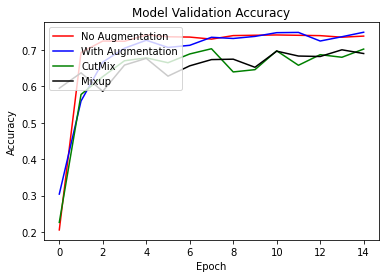

In [29]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'black')
plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.show()

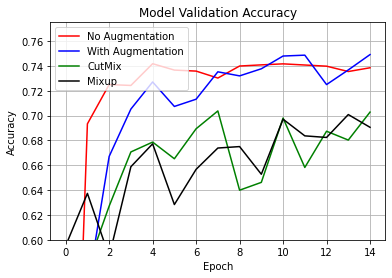

In [31]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'black')
plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.ylim(0.60, 0.775)
plt.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.show()

### 회고
no_augmentation, augmentation, cutmix, mixup을 구현하고 학습 후 그래프 시각화까지 해보았다. 결과를 보면 예상과 완전 딴판이었다. Epoch를 15회밖에 돌리지 않아서 그런지 cutmix, mixup을 한 결과가 더 낮게 나타나는 것을 볼 수 있었다. 아무래도 train dataset에 augmentation으로 인해 큰 변화가 있어서 그런지 accuracy가 더 낮게 나왔다고 추측했다.

augmentation을 적용한다고 해서 무조건 accuracy가 높아지는 것은 아니라고 한다.

하지만 그 이유에 대해서 세부적으로 알고 싶었지만 더 다양한 augmentation 방법이 많고 다른 부분을 좀 더 이해하는 게 더 나은 방법이라고 생각해서 오늘은 여기까지 하겠다.